# Ranking de desenvolvedores relativo ao perfil de tecnologias

O nosso modelo gerara uma lista de usuarios rankeados de acordo com a compatibilidade com uma lista de tecnologias especificada.

      Exemplo de Lista de tecnologias/linguagens =['JavaScript','JavaScript','Python','JavaScript','JavaScript','C++','JavaScript','Lua','C']

    Você pode repetir uma tecnologias quantas vzs quiser, isso aumenta o peso da tecnologia especifica, e ajuda a encontrar devs mais especialistas.


Usaremos a estrutura de comunidades encontradas na rede de seguidores para testar se os devs rankeados estão na mesma comunidade.

In [1]:
# %%time

import pandas as pd
import numpy as np
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.style.use('ggplot')


# from bokeh.plotting import figure, show
# from bokeh.models import Range1d, NumeralTickFormatter, FixedTicker, Legend
# from bokeh.palettes import Set1_7, RdBu5, RdBu11
# from bokeh.io import output_notebook
# output_notebook()

% matplotlib inline

from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.models import Word2Vec
from multiprocessing import cpu_count
from gensim.similarities import MatrixSimilarity, SparseMatrixSimilarity, SoftCosineSimilarity

# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
# Image(url="http://www.revistaforum.com.br/blogdorovai/wp-content/uploads/2014/01/grafico-inflacao.jpg")

In [2]:
users_repositories = pd.read_csv('../data/users__repositories.csv', dtype=str, na_values=[""])
users_repositories.head()

,User,Repo_Member,mRepo_Language,Repo_Owner,oRepo_Language
0,tarruda,libmpack/libmpack,C,"tarruda/Algoritmos,tarruda/archdb,tarruda/back...","JavaScript,JavaScript,JavaScript,JavaScript,Py..."
1,mairatma,"deprecate/steel-avatar,deprecate/steel-cell-de...","CSS,CSS,HTML,CSS,HTML,CSS,JavaScript,CSS,JavaS...","mairatma/alloy-ui,mairatma/alloyui.com,mairatm...","JavaScript,JavaScript,TypeScript,JavaScript,Ja..."
2,joselitojunior1,"acmh/maecoruja,Cisneiros/projeto-anfa,demianbo...","JavaScript,Java,Java,HTML,JavaScript,None","joselitojunior1/abigobaldo-nunes-adventures,jo...","JavaScript,HTML,CSS,None,None,None,None,GCC Ma..."
3,marcelcaraciolo,"irgmedeiros/TCCRecommender,jg1141/Open-Allure-DS","Python,Python","marcelcaraciolo/apontador-api-libs,marcelcarac...","PHP,Python,Python,None,Python,Python,Python,No..."
4,luanfonceca,"andrezap/analise_expressao_genica,andrezap/arv...","Java,Java,Java,Ruby,Ruby,JavaScript,JavaScript...","luanfonceca/168horas,luanfonceca/4stoq,luanfon...","CSS,Ruby,Python,JavaScript,Python,Python,None,..."


In [3]:

users_repositories.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1992 entries, 0 to 1991
Data columns (total 5 columns):
User              1992 non-null object
Repo_Member       785 non-null object
mRepo_Language    785 non-null object
Repo_Owner        1630 non-null object
oRepo_Language    1630 non-null object
dtypes: object(5)
memory usage: 77.9+ KB


In [4]:
users_repositories.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 748 entries, 0 to 1990
Data columns (total 5 columns):
User              748 non-null object
Repo_Member       748 non-null object
mRepo_Language    748 non-null object
Repo_Owner        748 non-null object
oRepo_Language    748 non-null object
dtypes: object(5)
memory usage: 35.1+ KB


In [5]:
users_repositories['Repo_Member'].apply(lambda x: list([l for l in str(x).split(',') if l!='None' and l!='']))
users_repositories.head()

,User,Repo_Member,mRepo_Language,Repo_Owner,oRepo_Language
0,tarruda,libmpack/libmpack,C,"tarruda/Algoritmos,tarruda/archdb,tarruda/back...","JavaScript,JavaScript,JavaScript,JavaScript,Py..."
1,mairatma,"deprecate/steel-avatar,deprecate/steel-cell-de...","CSS,CSS,HTML,CSS,HTML,CSS,JavaScript,CSS,JavaS...","mairatma/alloy-ui,mairatma/alloyui.com,mairatm...","JavaScript,JavaScript,TypeScript,JavaScript,Ja..."
2,joselitojunior1,"acmh/maecoruja,Cisneiros/projeto-anfa,demianbo...","JavaScript,Java,Java,HTML,JavaScript,None","joselitojunior1/abigobaldo-nunes-adventures,jo...","JavaScript,HTML,CSS,None,None,None,None,GCC Ma..."
3,marcelcaraciolo,"irgmedeiros/TCCRecommender,jg1141/Open-Allure-DS","Python,Python","marcelcaraciolo/apontador-api-libs,marcelcarac...","PHP,Python,Python,None,Python,Python,Python,No..."
4,luanfonceca,"andrezap/analise_expressao_genica,andrezap/arv...","Java,Java,Java,Ruby,Ruby,JavaScript,JavaScript...","luanfonceca/168horas,luanfonceca/4stoq,luanfon...","CSS,Ruby,Python,JavaScript,Python,Python,None,..."


In [6]:
users_repositories.describe()

,User,Repo_Member,mRepo_Language,Repo_Owner,oRepo_Language
count,1992,785,785,1630,1630
unique,1981,764,413,1622,1207
top,palaciowagner,matheusacx/Discreta,Java,"ViniFlira/PetCare,ViniFlira/PetCareIOS",None
freq,2,3,78,2,132


In [7]:
# Filtrando e Transformando o dataframe para dados de interesse

repos_langs = pd.DataFrame({ 
    'User': users_repositories['User'],
    'Repos': (users_repositories['Repo_Member'] +','+ users_repositories['Repo_Owner']).fillna(''),
    'Languages': (users_repositories['mRepo_Language'] +','+ users_repositories['oRepo_Language']).fillna('')})
repos_langs.head()

,Languages,Repos,User
0,"C,JavaScript,JavaScript,JavaScript,JavaScript,...","libmpack/libmpack,tarruda/Algoritmos,tarruda/a...",tarruda
1,"CSS,CSS,HTML,CSS,HTML,CSS,JavaScript,CSS,JavaS...","deprecate/steel-avatar,deprecate/steel-cell-de...",mairatma
2,"JavaScript,Java,Java,HTML,JavaScript,None,Java...","acmh/maecoruja,Cisneiros/projeto-anfa,demianbo...",joselitojunior1
3,"Python,Python,PHP,Python,Python,None,Python,Py...","irgmedeiros/TCCRecommender,jg1141/Open-Allure-...",marcelcaraciolo
4,"Java,Java,Java,Ruby,Ruby,JavaScript,JavaScript...","andrezap/analise_expressao_genica,andrezap/arv...",luanfonceca


## Repositories

In [8]:
repos = repos_langs['Repos']\
            .apply(lambda x: str(x).split(','))\
            .apply(lambda x: [item[1] for item in [r.split('/') for r in x] if len(item) > 1])
repos

0       [libmpack, Algoritmos, archdb, backbone-deep-m...
1       [steel-avatar, steel-cell-deprecated, steel-dr...
2       [maecoruja, projeto-anfa, phonegapbootcampsite...
3       [TCCRecommender, Open-Allure-DS, apontador-api...
4       [analise_expressao_genica, arvoresLP2, Ilicita...
5       [Scream, HumQueCaro, ProjetoHumQueCaro, Projet...
6       [Analise_de_Dados_de_Redes_Sociais_com_Python,...
7       [css-grid-layout-manual, por-dentro-do-github,...
8       [pocket, django-apps-checklist, agendacultural...
9       [coinpricemonitor, TODO-list-single-page-appli...
10      [trellando, socketrace, android-watchlist, bad...
11                                                     []
12      [scm, deadlock-exception-paper, java-lock-dead...
13      [taste, IF1006-Projeto, gestaoAtletas, redu, a...
14      [all-animation, sample-wechat, femugpe, financ...
15      [ModSecurity-log-utilities, ModSecurity-Python...
16      [hackernewsbr, 1001, arrow, awesome-static-ana...
17      [cader

### Languages

In [9]:
# Selecao de caracteristicas: vetor de linguagens
languages = repos_langs['Languages'].apply(lambda x: list([l for l in str(x).split(',') if l!='None' and l!='']))
languages.head()

0    [C, JavaScript, JavaScript, JavaScript, JavaSc...
1    [CSS, CSS, HTML, CSS, HTML, CSS, JavaScript, C...
2    [JavaScript, Java, Java, HTML, JavaScript, Jav...
3    [Python, Python, PHP, Python, Python, Python, ...
4    [Java, Java, Java, Ruby, Ruby, JavaScript, Jav...
Name: Languages, dtype: object

In [10]:
# Distribuicao de tecnologias unicas/com repeticao

repo_langs_df = pd.DataFrame({
 'User': users_repositories['User'],
 'Langs_List': languages,
 'Langs_Count': languages.apply(len),
 'Langs_Count_Unique': languages.apply(set).apply(len),
    
 'Repos_List': repos,
 'Repos_Count': repos.apply(len),
 'Repos_Count_Unique': repos.apply(set).apply(len)
})

repo_langs_df.describe()


,Langs_Count,Langs_Count_Unique,Repos_Count,Repos_Count_Unique
count,1992.000000,1992.000000,1992.000000,1992.000000
mean,5.834839,1.814257,6.834337,6.453815
std,13.487510,3.049506,15.509549,14.763458
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,6.000000,3.000000,7.000000,7.000000
max,149.000000,19.000000,161.000000,159.000000


In [11]:
repo_langs_df.iloc[:10]

,Langs_Count,Langs_Count_Unique,Langs_List,Repos_Count,Repos_Count_Unique,Repos_List,User
0,149,16,"[C, JavaScript, JavaScript, JavaScript, JavaSc...",157,157,"[libmpack, Algoritmos, archdb, backbone-deep-m...",tarruda
1,97,5,"[CSS, CSS, HTML, CSS, HTML, CSS, JavaScript, C...",101,97,"[steel-avatar, steel-cell-deprecated, steel-dr...",mairatma
2,42,10,"[JavaScript, Java, Java, HTML, JavaScript, Jav...",58,57,"[maecoruja, projeto-anfa, phonegapbootcampsite...",joselitojunior1
3,35,9,"[Python, Python, PHP, Python, Python, Python, ...",43,43,"[TCCRecommender, Open-Allure-DS, apontador-api...",marcelcaraciolo
4,103,7,"[Java, Java, Java, Ruby, Ruby, JavaScript, Jav...",123,123,"[analise_expressao_genica, arvoresLP2, Ilicita...",luanfonceca
5,14,5,"[Java, Java, Java, HTML, PHP, HTML, Java, Java...",22,18,"[Scream, HumQueCaro, ProjetoHumQueCaro, Projet...",deividazevedo2
6,58,7,"[Jupyter Notebook, Python, Python, Python, Jup...",69,69,"[Analise_de_Dados_de_Redes_Sociais_com_Python,...",gileno
7,24,8,"[JavaScript, Java, PHP, Ruby, JavaScript, Java...",42,41,"[css-grid-layout-manual, por-dentro-do-github,...",simoneas02
8,44,9,"[Python, HTML, HTML, JavaScript, Matlab, Pytho...",45,45,"[pocket, django-apps-checklist, agendacultural...",filipeximenes
9,31,6,"[Python, Python, JavaScript, JavaScript, JavaS...",36,33,"[coinpricemonitor, TODO-list-single-page-appli...",renatooliveira


In [12]:
repo_langs_df.sort_values(ascending=False, by="Langs_Count_Unique")[0:100]

,Langs_Count,Langs_Count_Unique,Langs_List,Repos_Count,Repos_Count_Unique,Repos_List,User
30,41,19,"[CSS, Processing, Python, C#, Objective-C, Pyt...",45,44,"[analisecandidatos, hackathonmj, triangle_visu...",pcstl
484,75,18,"[CSS, R, R, R, R, R, C, R, HTML, Shell, Python...",84,84,"[MapaExpo2016, CosW, SecKW, SinIW, TanB, abjDa...",lgallindo
82,62,17,"[PHP, CSS, Arduino, Python, Objective-C, HTML,...",99,99,"[startuppe-representmap, academiadacidade, Sky...",yelken
101,54,17,"[Python, JavaScript, Java, Vim script, CSS, Ja...",62,62,"[Django_eh_massa, SINS-WEB, DI_progs, .vim, 20...",itsmealves
0,149,16,"[C, JavaScript, JavaScript, JavaScript, JavaSc...",157,157,"[libmpack, Algoritmos, archdb, backbone-deep-m...",tarruda
13,132,16,"[Python, Ruby, Cucumber, Java, JavaScript, Gro...",149,148,"[taste, IF1006-Projeto, gestaoAtletas, redu, a...",henvic
65,56,15,"[Ruby, JavaScript, JavaScript, JavaScript, Go,...",65,64,"[anonydog, testing-contributor_repo, testing-m...",thiagoarrais
76,94,15,"[HTML, Clojure, Ruby, Ruby, CSS, Puppet, CSS, ...",105,102,"[gitslides, my_ultimate_repo, aulas-css, stone...",akshaykarle
28,114,14,"[Java, FreeMarker, JavaScript, Java, JavaScrip...",120,119,"[com-liferay-dynamic-data-mapping, frontend-tr...",brunobasto
217,145,14,"[JavaScript, PHP, PHP, Java, PHP, HTML, HTML, ...",161,159,"[alps, alps-wordpress, mala_direta_email, noti...",meirinaldojunior


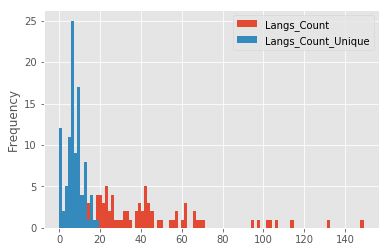

In [13]:
repo_langs_df[['Langs_Count', 'Langs_Count_Unique']][:100].plot.hist(bins=100);

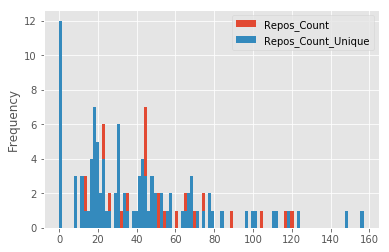

In [14]:
repo_langs_df[['Repos_Count', 'Repos_Count_Unique']][:100].plot.hist(bins=100);

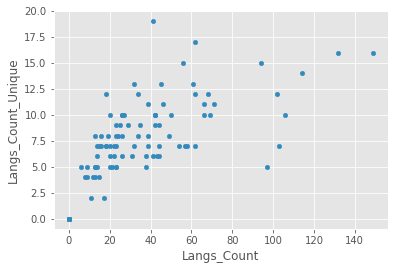

In [15]:
# Qtd pessoas x qtd de tecnologias unicas
repo_langs_df[:100].plot.scatter(x="Langs_Count", y="Langs_Count_Unique");

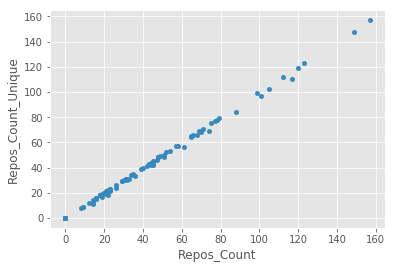

In [16]:
repo_langs_df[:100].plot.scatter(x="Repos_Count", y="Repos_Count_Unique");

In [17]:
repo_langs_df.Langs_Count.unique()

array([149,  97,  42,  35, 103,  14,  58,  24,  44,  31,  46,   0,  26,
       132, 102,  34,  62,  66,  41,  16,  22,  15,  38,  43,  21, 114,
        54,  71,  19,  17,  23,  29,  32,  68,  20,  11,  18,  50, 106,
        45,  13,  27,  56,  39,  57,   9,   6,  94,  25,  61,  69,   8,
        12,  49,  36,  33,  47,  28,   7,   4,  48,  40,   3,  81,   5,
        10,  60, 145,   2,  30,   1,  75,  79,  96,  84])

In [18]:
repo_langs_df.Repos_Count.unique()

array([157, 101,  58,  43, 123,  22,  69,  42,  45,  36,  57,   0,  31,
       149, 117,  39,  71,  77,  44,  52,  18,  23,  21, 120,  49,  61,
        74,  70,  88,  19,  48,  33,  78,  65,  14,  40,  47,  66, 112,
        35,  51,  29,  34,  54,  30,  68,   9,  16, 105,  26,  20,  99,
        75,  32,  79,   8,  12,  62,  25,  17,  11,  24,  55,  59,  10,
         4,  50,   3,  84,   6,  13,  28,  27,  60,  15, 161,   5,   7,
        38,  37,  41,   2,  85, 114, 104, 102])

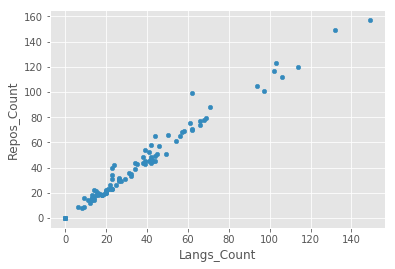

In [19]:
repo_langs_df[:100].plot.scatter(x="Langs_Count", y="Repos_Count");

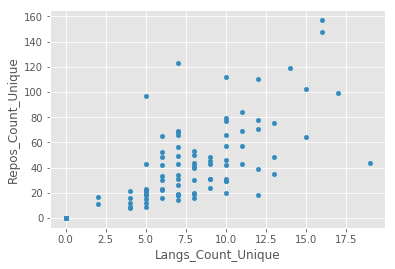

In [20]:
repo_langs_df[:100].plot.scatter(x="Langs_Count_Unique", y="Repos_Count_Unique");

## Construindo o dicionario de linguagens: tokens

In [21]:
#  building langs dictionary
repos_dictionary = Dictionary(repos)

print("Number of unique words: %d" % len(repos_dictionary))
print(repos_dictionary)

Number of unique words: 10826
Dictionary(10826 unique tokens: ['Algoritmos', 'CodeMirror', 'DefinitelyTyped', 'MaidSafe', 'MemoryModule']...)


In [22]:
repo_terms = repos_dictionary.token2id
print(repo_terms)

{'Algoritmos': 0, 'CodeMirror': 1, 'DefinitelyTyped': 2, 'MaidSafe': 3, 'MemoryModule': 4, 'URLON': 5, 'VBoxTrayIcon': 6, 'YouCompleteMe': 7, 'archdb': 8, 'backbone-deep-model': 9, 'backbone-jquerymobile': 10, 'beets': 11, 'better-sqlite3': 12, 'bootstrap-datetimepicker': 13, 'brightray': 14, 'buffer-prefix-range': 15, 'busted': 16, 'check': 17, 'classic': 18, 'closure-externs': 19, 'coffeelint-camel-case-vars': 20, 'coffeelint-no-explicit-parens': 21, 'coffeelint-no-implicit-returns': 22, 'consolidate.js': 23, 'continuum': 24, 'debian-packages': 25, 'deps': 26, 'dot-files': 27, 'electron': 28, 'encfs': 29, 'es6transform': 30, 'escope': 31, 'esprima': 32, 'evio': 33, 'expect.js': 34, 'git': 35, 'gitter-irc-bot': 36, 'grunt-coffee-build': 37, 'grunt-contrib-watch': 38, 'grunt-exec-jshint': 39, 'grunt-init-js-commonjs': 40, 'grunt-init-node-browser-commonjs': 41, 'grunt-mocha-debug': 42, 'grunt-traceur-build': 43, 'gulp': 44, 'gulp-typescript': 45, 'has': 46, 'hashlanguage': 47, 'haskell

In [23]:
#  building dictionary based on languages dataset
dictionary = Dictionary(languages)
print("Number of unique words: %d" % len(dictionary))
print(dictionary)


Number of unique words: 100
Dictionary(100 unique tokens: ['C', 'C++', 'CMake', 'CoffeeScript', 'HTML']...)


In [24]:
# Com o dicionario de tokens é possivel criar um dataframe com os valores do tf-idf de linguagens pra cada usuario
lang_terms = dictionary.token2id
print(lang_terms)

{'C': 0, 'C++': 1, 'CMake': 2, 'CoffeeScript': 3, 'HTML': 4, 'Haskell': 5, 'Java': 6, 'JavaScript': 7, 'Lua': 8, 'Makefile': 9, 'Perl': 10, 'Python': 11, 'Ruby': 12, 'Shell': 13, 'TypeScript': 14, 'VimL': 15, 'CSS': 16, 'GCC Machine Description': 17, 'Go': 18, 'PHP': 19, 'Objective-C': 20, 'Jupyter Notebook': 21, 'Vue': 22, 'Matlab': 23, 'Vim script': 24, 'XML': 25, 'ActionScript': 26, 'C#': 27, 'D': 28, 'Swift': 29, 'TeX': 30, 'Assembly': 31, 'Cucumber': 32, 'Groovy': 33, 'R': 34, 'FreeMarker': 35, 'PostScript': 36, 'VHDL': 37, 'Verilog': 38, 'Scala': 39, 'Kotlin': 40, 'Web Ontology Language': 41, 'Handlebars': 42, 'Arduino': 43, 'Eagle': 44, 'KiCad': 45, 'Elixir': 46, 'Elm': 47, 'Emacs Lisp': 48, 'NSIS': 49, 'Processing': 50, 'Rust': 51, 'Prolog': 52, 'Scheme': 53, 'Gherkin': 54, 'Clojure': 55, 'HCL': 56, 'Haxe': 57, 'NewLisp': 58, 'Common Lisp': 59, 'DOT': 60, 'XSLT': 61, 'PowerShell': 62, 'ANTLR': 63, 'Erlang': 64, 'Puppet': 65, 'ApacheConf': 66, 'PLpgSQL': 67, 'Racket': 68, 'Cryst

## Features: TF-IDF (TermFrequency-InverseDocumentFrequency)

Iremos aplicar o modelo de tf-idf, já que queremos dar foco no peso da tecnologia por pessoa (frequencia que a tecnologia aparece) tendo em vista que que a ocorrencia da tecnologia não é muito comum entre todos os usuários. 

Metricas do github: Users by Languages
* [373   Java](https://github.com/search?l=Java&q=location%3ARecife&type=Users )
* [256   JavaScript](https://github.com/search?l=JavaScript&q=location%3ARecife&type=Users )
* [165 Python](https://github.com/search?l=Python&q=location%3ARecife&type=Users )
* [126 HTML](https://github.com/search?l=HTML&q=location%3ARecife&type=Users )
* [103 PHP](https://github.com/search?l=PHP&q=location%3ARecife&type=Users )
* [77 Ruby](https://github.com/search?l=Ruby&q=location%3ARecife&type=Users )
* [72 CSS](https://github.com/search?l=CSS&q=location%3ARecife&type=Users )
* [54 C](https://github.com/search?l=C&q=location%3ARecife&type=Users )
* [41 C++](https://github.com/search?l=C%2B%2B&q=location%3ARecife&type=Users )
* [39 C#](https://github.com/search?l=C%23&q=location%3ARecife&type=Users)

O idf é necesario para normalizar os valores.

Na análise abaixo podemos checar a nossa hipótese

In [25]:
# Traing Model for predicions(similaridade): tf-idf\
tfidf = TfidfModel(dictionary=dictionary)
tfidf

In [26]:

lang_terms_list = list(lang_terms)
lang_terms_list[:10]

['C',
 'C++',
 'CMake',
 'CoffeeScript',
 'HTML',
 'Haskell',
 'Java',
 'JavaScript',
 'Lua',
 'Makefile']

** Verificando hipotese: new_doc é nosso projeto alvo **

Vamos configurar um novo conjunto de techs(new_doc) para encontrar usuarios compatíveis.


In [27]:
# Novo Dado a ser rankeado
new_doc = ['JavaScript','JavaScript','Python','JavaScript','JavaScript','C++','JavaScript','Lua','C'] # novo exemplo

# Transformando novo exemplo em vetor de (TF) legend = (lang_nr, freq)
new_vec = dictionary.doc2bow(new_doc) # term frequency vector
new_vec

[(0, 1), (1, 1), (7, 5), (8, 1), (11, 1)]

In [28]:
# É facil ver que o valor estimado para o termo 7=Javascript é maior

new_vec_tfidf = tfidf[new_vec] # Valor do tfidf pra cada termo em new_vec
new_vec_tfidf

[(0, 0.2544226420392753),
 (1, 0.2679520076775512),
 (7, 0.7610542410669464),
 (8, 0.4989679145224941),
 (11, 0.18787842672965765)]

In [29]:
keys, values = zip(*new_vec)
freq_vector = pd.DataFrame([values],columns=[(lang_terms_list[idx]) for idx in keys])
freq_vector 

,C,C++,JavaScript,Lua,Python
0,1,1,5,1,1


In [30]:
# Codificamos assim cada usuario pra seu vetor tf->
# Transforming dataset values
# vetor de frequencia de palavras = techs freq

bow_corpus = [dictionary.doc2bow(text) for text in languages] # frequency vector for all languages dataset
bow_corpus[:2]

[[(0, 11),
  (1, 13),
  (2, 1),
  (3, 13),
  (4, 2),
  (5, 1),
  (6, 3),
  (7, 67),
  (8, 5),
  (9, 1),
  (10, 1),
  (11, 14),
  (12, 3),
  (13, 4),
  (14, 2),
  (15, 8)],
 [(4, 7), (6, 1), (7, 81), (14, 2), (16, 6)]]

In [31]:
# Cria dataframe com o freq-terms

repo_langs_df['Lang_corpus'] = repo_langs_df['Langs_List'] \
                                .apply(dictionary.doc2bow)\
                                .apply(lambda x: sorted(x, key=lambda lang_term: lang_term[1], reverse=True))

repo_langs_df['Lang_corpus_df'] = repo_langs_df['Lang_corpus'] \
                                    .apply(lambda x: list(zip(*x))) \
                                    .apply(lambda x: pd.DataFrame() if len(x)<2 else pd.DataFrame([x[1]],
                                                                                      columns=[lang_terms_list[idx] for idx in x[0]]))
# pd.EmptyDataFrame()

repo_langs_df.head()

,Langs_Count,Langs_Count_Unique,Langs_List,Repos_Count,Repos_Count_Unique,Repos_List,User,Lang_corpus,Lang_corpus_df
0,149,16,"[C, JavaScript, JavaScript, JavaScript, JavaSc...",157,157,"[libmpack, Algoritmos, archdb, backbone-deep-m...",tarruda,"[(7, 67), (11, 14), (1, 13), (3, 13), (0, 11),...",JavaScript Python C++ CoffeeScript C ...
1,97,5,"[CSS, CSS, HTML, CSS, HTML, CSS, JavaScript, C...",101,97,"[steel-avatar, steel-cell-deprecated, steel-dr...",mairatma,"[(7, 81), (4, 7), (16, 6), (14, 2), (6, 1)]",JavaScript HTML CSS TypeScript Java 0 ...
2,42,10,"[JavaScript, Java, Java, HTML, JavaScript, Jav...",58,57,"[maecoruja, projeto-anfa, phonegapbootcampsite...",joselitojunior1,"[(4, 13), (7, 13), (16, 4), (6, 3), (19, 3), (...",HTML JavaScript CSS Java PHP TypeScrip...
3,35,9,"[Python, Python, PHP, Python, Python, Python, ...",43,43,"[TCCRecommender, Open-Allure-DS, apontador-api...",marcelcaraciolo,"[(11, 27), (0, 1), (7, 1), (10, 1), (12, 1), (...",Python C JavaScript Perl Ruby Shell C...
4,103,7,"[Java, Java, Java, Ruby, Ruby, JavaScript, Jav...",123,123,"[analise_expressao_genica, arvoresLP2, Ilicita...",luanfonceca,"[(11, 55), (7, 25), (16, 9), (12, 6), (6, 5), ...",Python JavaScript CSS Ruby Java HTML ...


In [32]:
# [langs_df.bow_corpus_df.iloc[tr[0]].plot.bar() for tr in top_recs_soft[:5]]
# .plot.bar()
# languages_frequency
repo_langs_df.Lang_corpus_df.iloc[2].iloc[0].keys()[0]

'HTML'

## Modelo para predição Similaridade de cosseno

Para encontrar perfis transversais tentamos usar o modelo Similaridade de cosseno.

Cosine similarity ou Similaridade de cosseno ou Semelhança de cosseno

A semelhança de cosseno é uma medida de similaridade(ou distância) entre dois vetores não nulos de um espaço de produto interno que mede o cosseno do ângulo entre eles. O cosseno de 0° é 1, e é menor que 1 para qualquer outro ângulo no intervalo [0,0.5π), portanto, um julgamento de orientação e não magnitude: dois vetores com a mesma orientação têm uma semelhança de cosseno de 1, dois vetores orientados a 90° um em relação ao outro têm uma semelhança de 0, e dois vetores diametralmente opostos têm uma semelhança de -1, independente de sua magnitude. A semelhança de cosseno é particularmente usada no espaço positivo, onde o resultado é nitidamente limitado em {\ displaystyle [0,1]} [0,1]. O nome deriva do termo "direção cosseno": neste caso, os vetores unitários são maximamente "similares" se forem paralelos e maximamente "dissimilares" se forem ortogonais (perpendiculares). Isso é análogo ao cosseno, que é a unidade (valor máximo) quando os segmentos subtendem um ângulo zero e zero (não correlacionado) quando os segmentos são perpendiculares.

[From Wikipedia, the free encyclopedia](https://en.wikipedia.org/wiki/Cosine_similarity)

In [33]:
# Model: Calculo de similaridade com Cosin

index = SparseMatrixSimilarity(tfidf[bow_corpus], num_features=102)

# LISTA DE TOP 10 USUARIOS RECOMENDADOS PARA NEW_DOC

In [34]:
similarities = index[tfidf[new_vec]]
recomendations = list(enumerate(similarities))
top_recs = sorted(recomendations, key=lambda rating: rating[1], reverse=True)
repos_langs.iloc[[tr[0] for tr in top_recs[:10]]]

,Languages,Repos,User
638,"JavaScript,Java,JavaScript,JavaScript,C,Python...","ahlp/owls_server,rafaellsma/transfer,renatohlf...",AleffSouza
1075,"JavaScript,JavaScript,Lua,JavaScript,Lua,JavaS...","ahlp/owls_server,reueljonathan/functions-game,...",reueljonathan
0,"C,JavaScript,JavaScript,JavaScript,JavaScript,...","libmpack/libmpack,tarruda/Algoritmos,tarruda/a...",tarruda
992,"Python,None,JavaScript,JavaScript,JavaScript,J...","raony/Iluminare2,marcuscarneiro/colabgame,marc...",marcuscarneiro
580,"JavaScript,HTML,C,JavaScript,JavaScript,JavaSc...","Colubris/parse-dashboard,felipemobile/awesome-...",felipemobile
197,"C,JavaScript,None,Python,C++,Python,Python,Jav...","clausiobarbosa/python-keccak_hash,hiagors92/hi...",leoreinaux
160,"Python,Python,JavaScript,JavaScript,CSS,HTML,C...","fpwanderley/projetobd,mmfrb/siscom,rodrigoalve...",acmh
133,"JavaScript,JavaScript,JavaScript,JavaScript","karlafalcao/astar-search,karlafalcao/crie-awe-...",FranciscoMarinho
707,"JavaScript,None","WandersonAlves/Portal-c3,felipeisidorio/apiRussia",felipeisidorio
1423,"JavaScript,JavaScript,JavaScript,JavaScript","bureauworks/mdPickers,bureauworks/slate,bureau...",bureauworks


In [35]:
top_recs[0]


(638, 0.87646866)

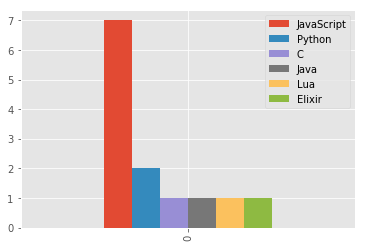

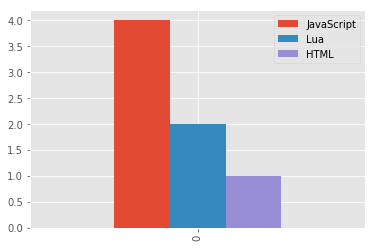

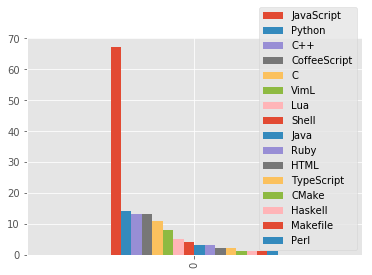

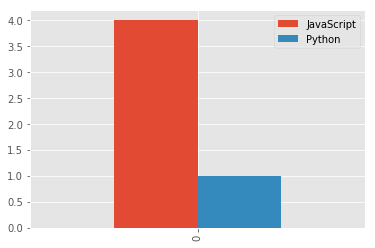

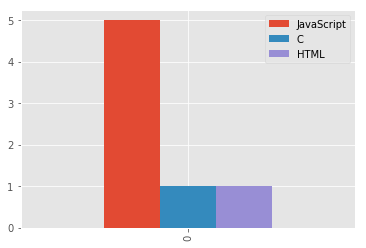

In [36]:
# Plotting the 5 top reccomendations

# langs_df.bow_corpus_df.iloc[top_recs[0][0]].plot.bar()
# langs_df.bow_corpus_df.iloc[top_recs[1][0]].plot.bar()
# langs_df.bow_corpus_df.iloc[top_recs[2][0]].plot.bar()
# langs_df.bow_corpus_df.iloc[top_recs[3][0]].plot.bar()
# langs_df.bow_corpus_df.iloc[top_recs[4][0]].plot.bar()

[repo_langs_df.Lang_corpus_df.iloc[tr[0]].plot.bar() for tr in top_recs[:5]]

#End.

## Extra: Resultados com o Algoritmo sofcosin

In [37]:
# Algoritmo: Calculo de similaridade com SofCosin

w2v_model = Word2Vec(languages, workers=cpu_count(), size=102, seed=12345)
similarity_matrix = w2v_model.wv.similarity_matrix(dictionary, tfidf, nonzero_limit=100)

index = SoftCosineSimilarity( tfidf[bow_corpus], similarity_matrix)


/Users/karlafalcao/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [38]:
similarities = index[tfidf[new_vec]]
recs_soft = list(enumerate(similarities))
print(recs_soft)

[(0, 0.9994308042505311), (1, 0.9884584685902753), (2, 0.9934596150242562), (3, 0.9616557555552838), (4, 0.9814387421991431), (5, 0.9851451291598405), (6, 0.9773673634468156), (7, 0.9976120208425088), (8, 0.9635329050903282), (9, 0.9769777882659328), (10, 0.9874018297543435), (11, 0.0), (12, 0.9901512674006665), (13, 0.9983265766260468), (14, 0.9956252588105506), (15, 0.9946756713406414), (16, 0.987891044792666), (17, 0.9852695904942204), (18, 0.9596545576626444), (19, 0.9970636375588365), (20, 0.9945817068075146), (21, 0.9938304043085274), (22, 0.9968764684830334), (23, 0.9952135052204427), (24, 0.9871625177145805), (25, 0.0), (26, 0.9796177076957453), (27, 0.0), (28, 0.9937863033216038), (29, 0.9783077829538828), (30, 0.9948227671841313), (31, 0.0), (32, 0.997023903612224), (33, 0.9948726526409842), (34, 0.9985816500102903), (35, 0.0), (36, 0.9852814432927457), (37, 0.9879822345938962), (38, 0.961704982503244), (39, 0.9948668619953257), (40, 0.9914080818642439), (41, 0.99169910249348

In [39]:
top_recs_soft = sorted(recs_soft, key=lambda rating: rating[1], reverse=True)
repos_langs.iloc[[tr[0] for tr in top_recs_soft[:10]]]

,Languages,Repos,User
638,"JavaScript,Java,JavaScript,JavaScript,C,Python...","ahlp/owls_server,rafaellsma/transfer,renatohlf...",AleffSouza
146,"Python,Python,None,Java,JavaScript,JavaScript,...","danisteps/Machine-Learning-Project,lucasns/pro...",foolOnTheHill
457,"JavaScript,JavaScript,Matlab,JavaScript,JavaSc...","acmh/gymquery,acmh/maecoruja,luisdelgado/Detec...",ntocampos
197,"C,JavaScript,None,Python,C++,Python,Python,Jav...","clausiobarbosa/python-keccak_hash,hiagors92/hi...",leoreinaux
160,"Python,Python,JavaScript,JavaScript,CSS,HTML,C...","fpwanderley/projetobd,mmfrb/siscom,rodrigoalve...",acmh
0,"C,JavaScript,JavaScript,JavaScript,JavaScript,...","libmpack/libmpack,tarruda/Algoritmos,tarruda/a...",tarruda
554,"None,PHP,None,Python,JavaScript,None,None,TeX,...","fss6/esd,tisstech/bootstrap-laravel-scaffold,d...",danilosoares
373,"JavaScript,Python,JavaScript,C#,PHP,JavaScript","FranciscoGileno/planning-poker,lpmourato/music...",tpmarcs
1075,"JavaScript,JavaScript,Lua,JavaScript,Lua,JavaS...","ahlp/owls_server,reueljonathan/functions-game,...",reueljonathan
105,"Java,JavaScript,JavaScript,JavaScript,JavaScri...","gfreivasc/uMQTT,casevictor/alloy,casevictor/al...",casevictor


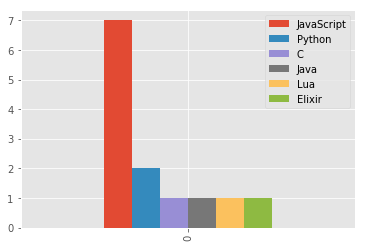

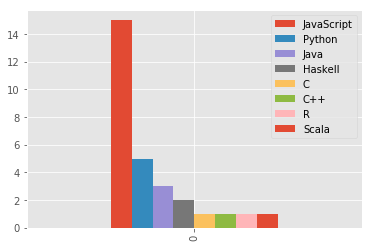

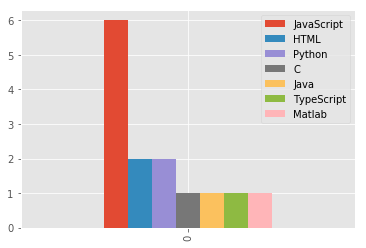

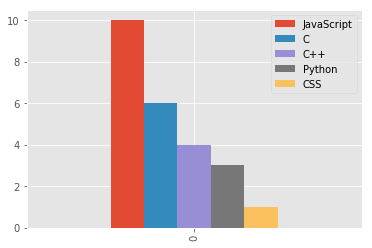

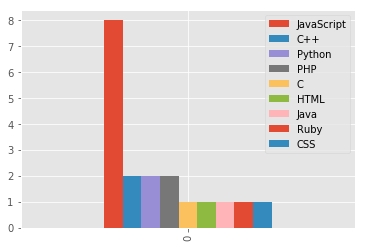

In [40]:
[repo_langs_df.Lang_corpus_df.iloc[tr[0]].plot.bar() for tr in top_recs_soft[:5]]

## Comunidades

In [80]:
communities = pd.read_csv('../data/communities.csv')
communities.head()

,User,fill
0,henriquemenezes,#df89ff
1,tarruda,#4c463e
2,paulolieuthier,#73c000
3,meiralins,#df89ff
4,dapine,#4c463e


In [81]:
repo_langs_df

,Langs_Count,Langs_Count_Unique,Langs_List,Repos_Count,Repos_Count_Unique,Repos_List,User,Lang_corpus,Lang_corpus_df
0,149,16,"[C, JavaScript, JavaScript, JavaScript, JavaSc...",157,157,"[libmpack, Algoritmos, archdb, backbone-deep-m...",tarruda,"[(7, 67), (11, 14), (1, 13), (3, 13), (0, 11),...",JavaScript Python C++ CoffeeScript C ...
1,97,5,"[CSS, CSS, HTML, CSS, HTML, CSS, JavaScript, C...",101,97,"[steel-avatar, steel-cell-deprecated, steel-dr...",mairatma,"[(7, 81), (4, 7), (16, 6), (14, 2), (6, 1)]",JavaScript HTML CSS TypeScript Java 0 ...
2,42,10,"[JavaScript, Java, Java, HTML, JavaScript, Jav...",58,57,"[maecoruja, projeto-anfa, phonegapbootcampsite...",joselitojunior1,"[(4, 13), (7, 13), (16, 4), (6, 3), (19, 3), (...",HTML JavaScript CSS Java PHP TypeScrip...
3,35,9,"[Python, Python, PHP, Python, Python, Python, ...",43,43,"[TCCRecommender, Open-Allure-DS, apontador-api...",marcelcaraciolo,"[(11, 27), (0, 1), (7, 1), (10, 1), (12, 1), (...",Python C JavaScript Perl Ruby Shell C...
4,103,7,"[Java, Java, Java, Ruby, Ruby, JavaScript, Jav...",123,123,"[analise_expressao_genica, arvoresLP2, Ilicita...",luanfonceca,"[(11, 55), (7, 25), (16, 9), (12, 6), (6, 5), ...",Python JavaScript CSS Ruby Java HTML ...
5,14,5,"[Java, Java, Java, HTML, PHP, HTML, Java, Java...",22,18,"[Scream, HumQueCaro, ProjetoHumQueCaro, Projet...",deividazevedo2,"[(6, 9), (4, 2), (7, 1), (11, 1), (19, 1)]",Java HTML JavaScript Python PHP 0 9...
6,58,7,"[Jupyter Notebook, Python, Python, Python, Jup...",69,69,"[Analise_de_Dados_de_Redes_Sociais_com_Python,...",gileno,"[(11, 31), (21, 12), (16, 6), (7, 5), (4, 2), ...",Python Jupyter Notebook CSS JavaScript ...
7,24,8,"[JavaScript, Java, PHP, Ruby, JavaScript, Java...",42,41,"[css-grid-layout-manual, por-dentro-do-github,...",simoneas02,"[(7, 13), (4, 5), (6, 1), (11, 1), (12, 1), (1...",JavaScript HTML Java Python Ruby CSS ...
8,44,9,"[Python, HTML, HTML, JavaScript, Matlab, Pytho...",45,45,"[pocket, django-apps-checklist, agendacultural...",filipeximenes,"[(11, 30), (4, 3), (7, 3), (12, 2), (16, 2), (...",Python HTML JavaScript Ruby CSS Object...
9,31,6,"[Python, Python, JavaScript, JavaScript, JavaS...",36,33,"[coinpricemonitor, TODO-list-single-page-appli...",renatooliveira,"[(11, 18), (7, 8), (13, 2), (0, 1), (4, 1), (1...",Python JavaScript Shell C HTML CSS 0 ...


In [82]:
merged_data = communities.merge(right=repo_langs_df, on='User')

In [83]:
merged_data

,User,fill,Langs_Count,Langs_Count_Unique,Langs_List,Repos_Count,Repos_Count_Unique,Repos_List,Lang_corpus,Lang_corpus_df
0,henriquemenezes,#df89ff,23,9,"[Go, Go, Python, Python, C++, Ruby, Java, Ruby...",31,31,"[gin-example-api, android-open-source-apps, an...","[(11, 5), (12, 5), (13, 4), (18, 3), (23, 2), ...",Python Ruby Shell Go Matlab C++ Java ...
1,tarruda,#4c463e,149,16,"[C, JavaScript, JavaScript, JavaScript, JavaSc...",157,157,"[libmpack, Algoritmos, archdb, backbone-deep-m...","[(7, 67), (11, 14), (1, 13), (3, 13), (0, 11),...",JavaScript Python C++ CoffeeScript C ...
2,paulolieuthier,#73c000,18,12,"[Java, HTML, JavaScript, Java, Go, C++, C++, P...",18,18,"[PCD_Middleware, criterion, meucongressonacion...","[(1, 4), (6, 3), (7, 2), (0, 1), (4, 1), (5, 1...",C++ Java JavaScript C HTML Haskell CS...
3,meiralins,#df89ff,23,5,"[Matlab, JavaScript, Python, Python, Python, P...",25,25,"[aprendizagem, clipboard.js, cookiecutter-tapi...","[(11, 18), (23, 2), (4, 1), (7, 1), (15, 1)]",Python Matlab HTML JavaScript VimL 0 ...
4,dapine,#4c463e,0,0,[],0,0,[],[],Empty DataFrame Columns: [] Index: []
5,spider8,#4c463e,0,0,[],0,0,[],[],Empty DataFrame Columns: [] Index: []
6,simoneas02,#ff5584,24,8,"[JavaScript, Java, PHP, Ruby, JavaScript, Java...",42,41,"[css-grid-layout-manual, por-dentro-do-github,...","[(7, 13), (4, 5), (6, 1), (11, 1), (12, 1), (1...",JavaScript HTML Java Python Ruby CSS ...
7,mairatma,#00c4ff,97,5,"[CSS, CSS, HTML, CSS, HTML, CSS, JavaScript, C...",101,97,"[steel-avatar, steel-cell-deprecated, steel-dr...","[(7, 81), (4, 7), (16, 6), (14, 2), (6, 1)]",JavaScript HTML CSS TypeScript Java 0 ...
8,henvic,#00c4ff,132,16,"[Python, Ruby, Cucumber, Java, JavaScript, Gro...",149,148,"[taste, IF1006-Projeto, gestaoAtletas, redu, a...","[(7, 58), (18, 33), (6, 10), (12, 5), (19, 5),...",JavaScript Go Java Ruby PHP HTML Pyth...
9,diegonvs,#00c4ff,68,12,"[Arduino, JavaScript, CSS, JavaScript, HTML, J...",78,78,"[Genius-Game, pomodoro-native, rotation-projec...","[(7, 38), (4, 8), (16, 5), (6, 4), (12, 3), (5...",JavaScript HTML CSS Java Ruby Haskell ...


In [94]:
merged_data.sort_values('fill', axis=0, ascending=True, inplace=True)
merged_data

,User,fill,Langs_Count,Langs_Count_Unique,Langs_List,Repos_Count,Repos_Count_Unique,Repos_List,Lang_corpus,Lang_corpus_df
158,Leviterus,#00bd94,9,6,"[CSS, JavaScript, VHDL, C++, HTML, CSS, JavaSc...",11,11,"[EudoClub, CodeCup-Cerberos, AutoSegeManager, ...","[(7, 3), (16, 2), (1, 1), (4, 1), (29, 1), (37...",JavaScript CSS C++ HTML Swift VHDL 0 ...
304,fehaa,#00bd94,8,4,"[HTML, JavaScript, TypeScript, CSS, TypeScript...",9,9,"[contact-list, beercalc, angular-2-project, io...","[(7, 4), (14, 2), (4, 1), (16, 1)]",JavaScript TypeScript HTML CSS 0 ...
306,ovictoraurelio,#00bd94,32,13,"[HTML, Java, C, JavaScript, CSS, Assembly, Ass...",35,35,"[SiteMonitoria, ac-fitness, algorithms, alu-bd...","[(7, 10), (0, 4), (4, 3), (16, 3), (1, 2), (13...",JavaScript C HTML CSS C++ Shell Assem...
756,diegotsouza83,#00bd94,0,0,[],0,0,[],[],Empty DataFrame Columns: [] Index: []
546,MichaelBarney,#00bd94,8,5,"[Java, Python, C, VHDL, HTML, HTML, C, Java]",10,9,"[synesthesiavision, StreetFighter_player, Tron...","[(0, 2), (4, 2), (6, 2), (11, 1), (37, 1)]",C HTML Java Python VHDL 0 2 2 ...
310,almdac,#00bd94,0,0,[],0,0,[],[],Empty DataFrame Columns: [] Index: []
311,jctvEC,#00bd94,0,0,[],0,0,[],[],Empty DataFrame Columns: [] Index: []
545,MiniMarvin,#00bd94,0,0,[],0,0,[],[],Empty DataFrame Columns: [] Index: []
14,iagobelo,#00bd94,23,7,"[HTML, TypeScript, Java, Java, Java, Java, Jav...",34,34,"[RecTeatro, butuka, rmonitor, agenda-contato, ...","[(6, 9), (7, 9), (1, 1), (4, 1), (11, 1), (14,...",Java JavaScript C++ HTML Python TypeSc...
340,Vitor0liveira,#00bd94,32,8,"[JavaScript, Java, Java, CSS, C#, PHP, Java, C...",43,39,[open-enrollment-classes-introduction-to-githu...,"[(6, 12), (7, 4), (14, 4), (27, 4), (4, 3), (1...",Java JavaScript TypeScript C# HTML CSS...


In [96]:
print( merged_data[['User', 'fill', 'Lang_corpus_df']][merged_data.fill == '#df89ff'] )
# print( merged_data[['User', 'fill', 'Lang_corpus_df']][merged_data.fill == '#4c463e'] )
# print( merged_data[['User', 'fill', 'Lang_corpus_df']][merged_data.fill == '#73c000'] )
# print( merged_data[['User', 'fill', 'Lang_corpus_df']][merged_data.fill == '#ff5584'] )
# print( merged_data[['User', 'fill', 'Lang_corpus_df']][merged_data.fill == '#00c4ff'] )
# print( merged_data[['User', 'fill', 'Lang_corpus_df']][merged_data.fill == '#00bd94'] )
# print( merged_data[['User', 'fill', 'Lang_corpus_df']][merged_data.fill == '#c0c0c0'] )
# print( merged_data[['User', 'fill', 'Lang_corpus_df']][merged_data.fill == '#ff8805'] )
# print( merged_data[['User', 'fill', 'Lang_corpus_df']][merged_data.fill == '#d3b3b0'] )

                User     fill  \
53       irgmedeiros  #df89ff   
333    felipechaulet  #df89ff   
419  andersonresende  #df89ff   
436     diogocaetano  #df89ff   
445   felipedemacedo  #df89ff   
472           rsarai  #df89ff   
470      brunosan7os  #df89ff   
497      debscorreia  #df89ff   
498      MarcusDEFGH  #df89ff   
500     andrebuarque  #df89ff   
127      warkentien2  #df89ff   
332          tvarjao  #df89ff   
51      filipevarjao  #df89ff   
202        victorfsf  #df89ff   
60       geocarvalho  #df89ff   
132    adailsonfilho  #df89ff   
61   jamissonfreitas  #df89ff   
62      wellington16  #df89ff   
63        klebercode  #df89ff   
65       angelobrito  #df89ff   
66           hugoesb  #df89ff   
503         citiufpe  #df89ff   
67       joaosantana  #df89ff   
68          wbgalvao  #df89ff   
69    deividazevedo2  #df89ff   
207     filipehsilva  #df89ff   
206        tuliocpbs  #df89ff   
205          arineto  #df89ff   
59    guilhermepaiva  #df89ff   
516       

In [212]:
# pink group
new_data = merged_data[['User', 'fill', 'Lang_corpus_df']][merged_data.fill == '#df89ff'].reset_index().drop('index', axis=1)
new_data

,User,fill,Lang_corpus_df
0,irgmedeiros,#df89ff,Python Ruby JavaScript CSS Jupyter Note...
1,felipechaulet,#df89ff,Empty DataFrame Columns: [] Index: []
2,andersonresende,#df89ff,Python HTML JavaScript CSS Makefile Sh...
3,diogocaetano,#df89ff,Ruby JavaScript HTML PHP Elixir 0 3...
4,felipedemacedo,#df89ff,Empty DataFrame Columns: [] Index: []
5,rsarai,#df89ff,Python Java C# HTML JavaScript Shell ...
6,brunosan7os,#df89ff,Empty DataFrame Columns: [] Index: []
7,debscorreia,#df89ff,Python CoffeeScript JavaScript CSS 0 ...
8,MarcusDEFGH,#df89ff,Python Java 0 3 1
9,andrebuarque,#df89ff,Ruby JavaScript Shell PHP Objective-C 0...


In [214]:

# concat all dataframes in langs corpus column
langs_concat = pd.concat(list(new_data.Lang_corpus_df), axis=0, join='outer')\
                .reset_index().drop('index', axis=1)\
                .dropna(axis='columns', how='all')
langs_concat

,ANTLR,ApacheConf,Arduino,Assembly,C,C#,C++,CMake,CSS,Clojure,...,Shell,Standard ML,Swift,TeX,TypeScript,VHDL,Verilog,Vim script,VimL,XML
0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


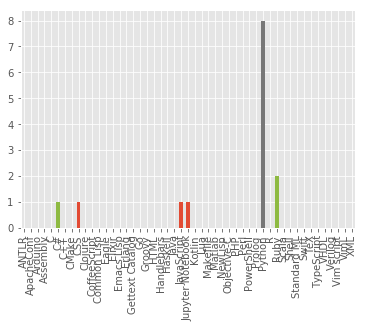

In [220]:
# plotting the first row
# langs_concat.iloc[0].plot.bar()

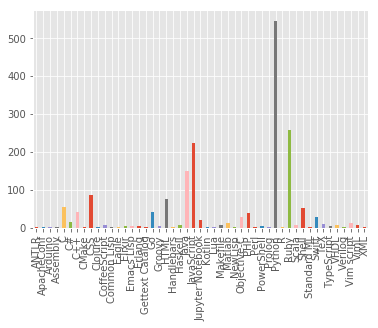

In [215]:
# Plot the sum of all rows
langs_concat.apply(np.sum, axis=0).plot.bar()

In [202]:
#00c4ff (azul)


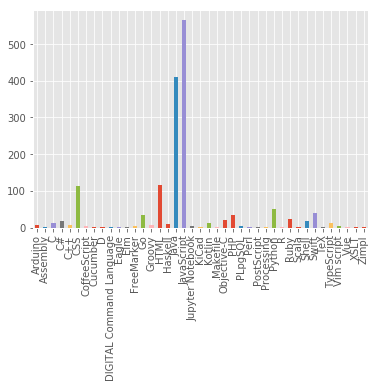

In [222]:
new_data = merged_data[['User', 'fill', 'Lang_corpus_df']][merged_data.fill == '#00c4ff'].reset_index().drop('index', axis=1)

langs_concat = pd.concat(list(new_data.Lang_corpus_df), axis=0, join='outer')\
                .reset_index().drop('index', axis=1)\
                .dropna(axis='columns', how='all')
langs_concat

langs_concat.apply(np.sum, axis=0).plot.bar()

In [223]:
#73c000 (verde)


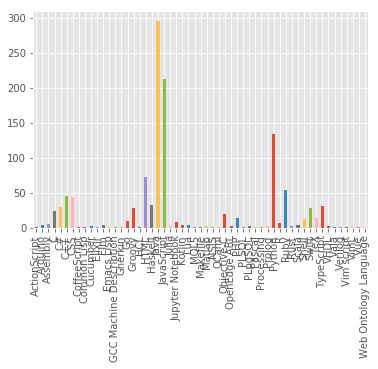

In [224]:
new_data = merged_data[['User', 'fill', 'Lang_corpus_df']][merged_data.fill == '#73c000'].reset_index().drop('index', axis=1)

langs_concat = pd.concat(list(new_data.Lang_corpus_df), axis=0, join='outer')\
                .reset_index().drop('index', axis=1)\
                .dropna(axis='columns', how='all')
langs_concat

langs_concat.apply(np.sum, axis=0).plot.bar()

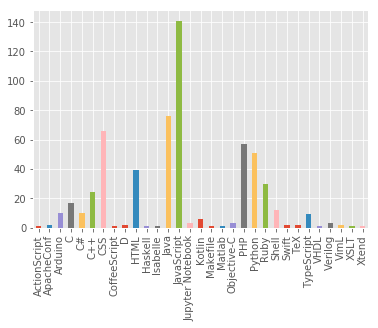

In [225]:
#ff8805 (orange)

new_data = merged_data[['User', 'fill', 'Lang_corpus_df']][merged_data.fill == '#ff8805'].reset_index().drop('index', axis=1)

langs_concat = pd.concat(list(new_data.Lang_corpus_df), axis=0, join='outer')\
                .reset_index().drop('index', axis=1)\
                .dropna(axis='columns', how='all')
langs_concat

langs_concat.apply(np.sum, axis=0).plot.bar()